In [1]:
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
import yfinance as yf
import pandas as pd
import datetime
import time
import talib
from talib import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import xgboost as xgb
import math
import numpy as np
from sklearn.decomposition import PCA
import pickle
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
yf.pdr_override()

In [2]:
def add_indicators():
        
    R_S_I = RSI(df['Adj Close'], timeperiod=slow)
    E_M_A = EMA(df['Adj Close'], timeperiod=fast)
    macd, macdsig, macdhist = MACD(df['Adj Close'], fastperiod=fast, slowperiod=slow, signalperiod=really_fast)
    mfi = MFI(df['High'], df['Low'], df['Adj Close'],df['Volume'],timeperiod=fast)
    slowk, slowd = STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=fast, slowk_period=slow, slowk_matype=0, slowd_period=slow, slowd_matype=0)
    
    #
    #
    #
    
    df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd
    
    
    
    ####
    
    

    #76 vars

    #are_all_zero = (test_TA == 0).all()
    #true if all values are 0
    #false if contain a non 0'''

    df.drop(['Close'], axis =1, inplace = True)

    

In [3]:
def add_lag(num_lag_cols, this_df):
    
    tic = time.perf_counter()
    
    '''df['ema'] = E_M_A
    df['rsi'] = R_S_I
    df['macd'] = macd
    df['macdsig'] = macdsig
    df['macdhist'] = macdhist
    df['mfi'] = mfi
    df['slowK'] = slowk
    df['slowD'] = slowd'''
    
    lag_cols = ['open',
                 'high',
                 'low',
                 'adj_close',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd']

    shift_range = [x+1 for x in range(num_lag_cols)]

    for shift in shift_range:
        train_shift = this_df[merging_keys + lag_cols].copy()

        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        this_df = pd.merge(this_df, train_shift, on=merging_keys, how='left') #.fillna(0)

    del train_shift
    
    toc = time.perf_counter()

    tic_toc = (toc - tic) / 60

    print(f"completed lagging in {tic_toc:0.4f} min")
    

    return this_df

In [4]:
def add_scale(num_interval_lag):

    cols_to_scale = ['open',#
                     'high',#
                     'low',#
                     'adj_close',#
                     'volume',#
                     'ema',#
                     'rsi',#
                     'macd',#
                     'macdsig',#
                     'macdhist',#
                     'mfi',#
                     'slowk',#
                     'slowd']#
                    

    for i in range(1,num_interval_lag+1):
        cols_to_scale.append("ema_lag_"+str(i))
        cols_to_scale.append("slowk_lag_"+str(i))
        cols_to_scale.append("slowd_lag_"+str(i))
        cols_to_scale.append("rsi_lag_"+str(i))

        cols_to_scale.append("volume_lag_"+str(i))

        cols_to_scale.append("adj_close_lag_"+str(i))
        
        cols_to_scale.append("open_lag_"+str(i))
        cols_to_scale.append("high_lag_"+str(i))
        cols_to_scale.append("low_lag_"+str(i))

        cols_to_scale.append("macd_lag_"+str(i))
        cols_to_scale.append("macdsig_lag_"+str(i))
        cols_to_scale.append("macdhist_lag_"+str(i))

        cols_to_scale.append("mfi_lag_"+str(i))
      
    return cols_to_scale

In [5]:
stock = 'AMD'

start_date = datetime.datetime.now() - datetime.timedelta(days=59)

end_date = datetime.datetime.now()

df = pdr.get_data_yahoo(stock, start=start_date, end=end_date, interval = "2m", prepost = True)

#df = pdr.get_data_yahoo(stock, period = "max", interval = "1d", prepost = True)

#df.index = df.index.tz_localize(None)

'''#2 min ticker
# 30 intervals = 1 hour << OLD
# 195 intervals = trading day'''
                                            # there are more intervals that we can use / change
really_fast = 30
fast = 60
slow = 90

add_indicators()

# Convert Date column to datetime
df.reset_index(level=0, inplace=True)

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

df['order_day'] = [x for x in list(range(len(df)))]
# merging_keys


# Get difference between high and low of each day

[*********************100%***********************]  1 of 1 completed


In [6]:
col_list = df.columns.to_list()
col_list.remove('datetime')

In [7]:
col_list

['open',
 'high',
 'low',
 'adj_close',
 'volume',
 'ema',
 'rsi',
 'macd',
 'macdsig',
 'macdhist',
 'mfi',
 'slowk',
 'slowd',
 'order_day']

In [8]:
merging_keys = ['order_day']

num_interval_lag = 30

df = add_lag(num_interval_lag, df)

#df['adj_close'] = df['adj_close'].shift(30)

completed lagging in 0.0309 min


In [9]:
print(df.shape)

(15071, 405)


In [10]:
print(df.head(40))

                    datetime     open     high      low  adj_close  volume  \
0  2021-01-06 19:00:00-05:00  90.6500  90.7000  90.6500    90.7000       0   
1  2021-01-06 19:02:00-05:00  90.6200  90.6800  90.6200    90.6800       0   
2  2021-01-06 19:04:00-05:00  90.6300  90.6300  90.6300    90.6300       0   
3  2021-01-06 19:06:00-05:00  90.6800  90.7000  90.6300    90.6300       0   
4  2021-01-06 19:08:00-05:00  90.6300  90.6300  90.6300    90.6300       0   
5  2021-01-06 19:10:00-05:00  90.6300  90.6301  90.6300    90.6300       0   
6  2021-01-06 19:12:00-05:00  90.6800  90.6800  90.6800    90.6800       0   
7  2021-01-06 19:14:00-05:00  90.6700  90.6700  90.6700    90.6700       0   
8  2021-01-06 19:16:00-05:00  90.6400  90.6800  90.6400    90.6800       0   
9  2021-01-06 19:18:00-05:00  90.6500  90.6500  90.6500    90.6500       0   
10 2021-01-06 19:20:00-05:00  90.6600  90.6600  90.6500    90.6500       0   
11 2021-01-06 19:22:00-05:00  90.6600  90.6600  90.6500    90.65

In [11]:
window_size = 30

df['adj_close'] = df['adj_close'].shift(-window_size)



In [12]:
cols_to_rem = ['open',
                 'high',
                 'low',
                 'volume',
                 'ema',
                 'rsi',
                 'macd',
                 'macdsig',
                 'macdhist',
                 'mfi',
                 'slowk',
                 'slowd',
                 'order_day']

In [13]:
close_vals_list = df['adj_close']

In [14]:
df.drop(cols_to_rem, axis = 1, inplace = True)

In [15]:
print(df.tail(40))

                       datetime  adj_close  open_lag_1  high_lag_1  low_lag_1  \
15031 2021-02-24 18:40:00-05:00      86.79       86.68       86.77    86.6200   
15032 2021-02-24 18:42:00-05:00      86.75       86.63       86.75    86.6200   
15033 2021-02-24 18:44:00-05:00      86.66       86.72       86.75    86.6200   
15034 2021-02-24 18:46:00-05:00      86.70       86.72       86.73    86.7000   
15035 2021-02-24 18:48:00-05:00      86.70       86.70       86.70    86.6500   
15036 2021-02-24 18:50:00-05:00      86.80       86.70       86.70    86.6000   
15037 2021-02-24 18:52:00-05:00      86.80       86.65       86.70    86.6000   
15038 2021-02-24 18:54:00-05:00      86.85       86.69       86.86    86.6500   
15039 2021-02-24 18:56:00-05:00      86.85       86.80       86.85    86.7500   
15040 2021-02-24 18:58:00-05:00      86.87       86.80       86.85    86.7501   
15041 2021-02-24 19:00:00-05:00        NaN       86.84       86.86    86.7500   
15042 2021-02-24 19:02:00-05

In [16]:


#close_vals_list = df['adj_close']

df.fillna(0, inplace=True)

#df.fillna(0, inplace=True)

#BUY => 1, SELL => 0, HOLD => 2

num_test = int(.10*len(df))
num_train = len(df) - num_test

# Split into train, cv, and test
train = df[:num_train]
test = df[num_train:]

#print(test['datetime'].iloc[[-1]])
#print(test['test_labels'].iloc[[-1]])

train_close_vals = close_vals_list[:num_train]
test_close_vals = close_vals_list[num_train:]

#test_dates_list = test['date']
#BUY => 1, SELL => 0, HOLD => 2

In [17]:
test_dates_list = test['datetime']

In [18]:
train_dates_list = train['datetime']

In [19]:
test_adj_close_list = close_vals_list[num_train:]

In [20]:
cols_to_scale = add_scale(num_interval_lag)
#cols_to_scale.remove(cols_to_rem)

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak


In [21]:
for element in cols_to_rem:

    if element in cols_to_scale:

        cols_to_scale.remove(element)

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
#scaler = StandardScaler()

scaler = MinMaxScaler(feature_range=(-1,1))

scaler.fit(train[cols_to_scale])
train_scaled = scaler.transform(train[cols_to_scale])

# Convert the numpy array back into pandas dataframe

train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled = train_scaled[slow:]
train = train[slow:]

#scaling test dataset

#scaler_2 = StandardScaler()

scaler_2  = MinMaxScaler(feature_range=(-1,1))
scaler_2.fit(test[cols_to_scale])
test_scaled = scaler_2.transform(test[cols_to_scale])

# Convert the numpy array back into pandas dataframe

test_scaled = pd.DataFrame(test_scaled, columns=cols_to_scale)

features = cols_to_scale

In [24]:
features

['adj_close',
 'ema_lag_1',
 'slowk_lag_1',
 'slowd_lag_1',
 'rsi_lag_1',
 'volume_lag_1',
 'adj_close_lag_1',
 'open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'macd_lag_1',
 'macdsig_lag_1',
 'macdhist_lag_1',
 'mfi_lag_1',
 'ema_lag_2',
 'slowk_lag_2',
 'slowd_lag_2',
 'rsi_lag_2',
 'volume_lag_2',
 'adj_close_lag_2',
 'open_lag_2',
 'high_lag_2',
 'low_lag_2',
 'macd_lag_2',
 'macdsig_lag_2',
 'macdhist_lag_2',
 'mfi_lag_2',
 'ema_lag_3',
 'slowk_lag_3',
 'slowd_lag_3',
 'rsi_lag_3',
 'volume_lag_3',
 'adj_close_lag_3',
 'open_lag_3',
 'high_lag_3',
 'low_lag_3',
 'macd_lag_3',
 'macdsig_lag_3',
 'macdhist_lag_3',
 'mfi_lag_3',
 'ema_lag_4',
 'slowk_lag_4',
 'slowd_lag_4',
 'rsi_lag_4',
 'volume_lag_4',
 'adj_close_lag_4',
 'open_lag_4',
 'high_lag_4',
 'low_lag_4',
 'macd_lag_4',
 'macdsig_lag_4',
 'macdhist_lag_4',
 'mfi_lag_4',
 'ema_lag_5',
 'slowk_lag_5',
 'slowd_lag_5',
 'rsi_lag_5',
 'volume_lag_5',
 'adj_close_lag_5',
 'open_lag_5',
 'high_lag_5',
 'low_lag_5',
 'macd_lag_5',
 '

In [25]:
features.remove('adj_close')

In [26]:
print('adj_close' in features)

False


In [27]:
print('adj_close' in train_scaled.columns)

True


In [28]:
#features.remove(target)

# Split into X and y
'''X_train_scaled = train_scaled[features]
y_train_scaled = train['labels']

X_test_scaled = test_scaled[features]
y_test_scaled = test['labels']'''

X_train = train_scaled[features]
y_train = train_scaled['adj_close']

X_test = test_scaled[features]
y_test = test_scaled['adj_close']

In [29]:
import pyswarms as ps
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error

In [30]:
def fitness_function(position):
    
    print(position)
    
    svrRegressor = SVR(kernel='rbf', gamma = position[0].all(), C = position[1].all() )
    
    svrRegressor.fit(X_train, y_train)
    
    y_train_pred = svrRegressor.predict(X_train)
    
    y_test_pred = svrRegressor.predict(X_test)
    
    mse_test =mean_squared_error(y_test, y_test_pred)
    
    rmse_test = math.sqrt(mse_test)
    
    print('Optimizing the Parameters ..... C = {c}, Gamma={gamma}'.format(c=position[1], gamma=position[0]))
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    rmse_train = math.sqrt(mse_train)
    
    #list(range(mse_f_train,rmse_f_train))
    retVal= rmse_test #Return a vector instead of single value. you can use the rmse_test and ignore rmse_train
    
    return retVal

In [31]:
lb = [10, 0.0001]
ub = [1000,0.1]
bounds = (lb,ub)

options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=2,options=options, bounds = bounds)
gamma_opt, C_opt = optimizer.optimize(fitness_function, iters=50)

2021-02-24 20:37:40,224 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|                                                                                |0/50

[[5.57423871e+02 9.38241316e-02]
 [6.46877503e+02 1.78757178e-02]
 [6.81279389e+02 4.26282311e-02]
 [8.56990366e+02 8.73405416e-02]
 [7.72030294e+02 6.09934323e-02]
 [7.45211952e+02 7.93712424e-02]
 [5.01107800e+02 4.31521256e-02]
 [9.24050451e+02 8.10847026e-02]
 [7.04271119e+02 1.87910617e-03]
 [9.68138611e+01 3.85649257e-02]
 [3.75438418e+02 9.83540623e-02]
 [7.12256621e+02 8.76775688e-02]
 [5.52464690e+02 6.70649467e-02]
 [1.36158698e+02 4.37930880e-02]
 [5.55745649e+01 3.48352890e-02]
 [4.47251507e+02 9.85274763e-03]
 [1.29647139e+02 7.98325650e-03]
 [5.98147528e+02 1.19433148e-02]
 [5.33705548e+02 7.34564682e-02]
 [4.02679638e+02 8.25218347e-02]]


pyswarms.single.global_best:   2%|█▎                                                             |1/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.46877503e+02 1.78757178e-02], Gamma=[5.57423871e+02 9.38241316e-02]
[[5.57516296e+02 7.96620629e-02]
 [6.33395252e+02 7.98615916e-02]
 [6.65912106e+02 1.56787620e-02]
 [8.55002887e+02 4.50272877e-02]
 [7.25161619e+02 1.67093306e-02]
 [7.16263631e+02 8.48189673e-02]
 [5.08769291e+02 4.60499414e-02]
 [8.23674597e+02 1.12071710e-02]
 [6.88426776e+02 3.35212025e-02]
 [2.18295531e+02 2.28991432e-02]
 [4.18597990e+02 6.24860628e-02]
 [6.77938387e+02 5.45870327e-02]
 [5.53577068e+02 2.55222799e-03]
 [2.61648692e+02 5.09208404e-02]
 [1.74776719e+02 2.46980098e-02]
 [4.58586386e+02 7.06391293e-02]
 [2.52008619e+02 8.73665237e-02]
 [5.96789284e+02 2.33426327e-02]
 [5.38497304e+02 2.78662796e-02]
 [4.09040989e+02 6.26441702e-02]]


pyswarms.single.global_best:   4%|██▌                                                            |2/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.33395252e+02 7.98615916e-02], Gamma=[5.57516296e+02 7.96620629e-02]
[[5.57571744e+02 1.16335838e-02]
 [6.15116130e+02 5.63107005e-02]
 [6.34244144e+02 5.52848579e-02]
 [7.70476903e+02 5.65703748e-02]
 [6.59523908e+02 1.12285922e-02]
 [6.63275877e+02 5.93355905e-02]
 [5.22411094e+02 3.37996995e-02]
 [7.11016962e+02 6.14069806e-02]
 [6.44264637e+02 6.72372562e-02]
 [4.16582503e+02 8.02735288e-02]
 [4.86142322e+02 3.76395098e-02]
 [6.38864176e+02 2.58323877e-03]
 [5.54803766e+02 5.91540358e-02]
 [3.72028436e+02 5.39319845e-02]
 [3.38682962e+02 5.53888578e-02]
 [4.92945084e+02 2.16823245e-02]
 [4.04873699e+02 9.71293763e-03]
 [5.91850904e+02 2.99119458e-02]
 [5.40856111e+02 9.86267193e-02]
 [4.39676792e+02 3.71168086e-02]]


pyswarms.single.global_best:   6%|███▊                                                           |3/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.15116130e+02 5.63107005e-02], Gamma=[5.57571744e+02 1.16335838e-02]
[[5.57523489e+02 3.97638566e-03]
 [5.97873877e+02 5.85574344e-02]
 [6.22092145e+02 5.74329106e-02]
 [7.03058318e+02 3.68236647e-02]
 [6.30177853e+02 6.93425081e-02]
 [6.27157034e+02 1.83440590e-02]
 [5.38214108e+02 1.00657110e-02]
 [6.68908560e+02 7.71321344e-04]
 [5.88876550e+02 9.59428646e-02]
 [5.34002294e+02 9.07710606e-02]
 [5.55226353e+02 2.58525873e-02]
 [6.00460584e+02 7.57762126e-02]
 [5.55376073e+02 6.11851940e-03]
 [4.40887640e+02 5.01308459e-02]
 [5.39792991e+02 2.71720103e-02]
 [5.21203766e+02 1.47996695e-02]
 [5.04258938e+02 8.57331738e-02]
 [5.85579085e+02 3.35028519e-02]
 [5.43903997e+02 5.65902538e-02]
 [4.95794311e+02 1.93957361e-02]]


pyswarms.single.global_best:   8%|█████                                                          |4/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.97873877e+02 5.85574344e-02], Gamma=[5.57523489e+02 3.97638566e-03]
[[5.57452594e+02 8.70968634e-02]
 [5.79259184e+02 6.81544819e-04]
 [5.99648134e+02 2.41134203e-02]
 [6.86124750e+02 9.05316281e-02]
 [6.10105746e+02 6.42414805e-02]
 [6.34293260e+02 9.40837514e-02]
 [5.40955417e+02 9.10264996e-02]
 [6.84204294e+02 4.64052314e-02]
 [5.71057421e+02 9.76343741e-02]
 [5.35103795e+02 5.28928792e-02]
 [6.07589372e+02 4.19948074e-02]
 [5.88567140e+02 2.54220263e-02]
 [5.56210533e+02 7.10355827e-02]
 [3.78531674e+02 4.01061777e-02]
 [6.84240509e+02 5.77352287e-02]
 [5.47973057e+02 4.70181147e-02]
 [4.76724920e+02 9.08874062e-02]
 [5.83110132e+02 2.96905442e-02]
 [5.43490145e+02 1.48148227e-02]
 [5.16482706e+02 3.58611270e-03]]


pyswarms.single.global_best:  10%|██████▎                                                        |5/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.79259184e+02 6.81544819e-04], Gamma=[5.57452594e+02 8.70968634e-02]
[[5.57382328e+02 2.70620727e-02]
 [5.59003229e+02 2.30748495e-03]
 [5.85876031e+02 7.26582771e-02]
 [6.99958809e+02 9.97487009e-02]
 [6.50084389e+02 1.27905297e-03]
 [6.68620402e+02 3.52583693e-02]
 [5.41070707e+02 3.85486093e-02]
 [7.23795137e+02 9.33247321e-02]
 [6.14828805e+02 6.02385552e-02]
 [3.81530764e+02 8.06004395e-02]
 [6.00639621e+02 7.24227778e-02]
 [6.23437291e+02 6.96813519e-02]
 [5.55305222e+02 2.36073979e-02]
 [2.44118071e+02 3.76669289e-02]
 [7.71403058e+02 2.66311173e-02]
 [5.59668907e+02 1.58228584e-02]
 [4.54787517e+02 4.79800786e-02]
 [5.81829807e+02 2.71055239e-02]
 [5.44354122e+02 7.41170889e-03]
 [5.02238062e+02 1.01490109e-02]]


pyswarms.single.global_best:  12%|███████▌                                                       |6/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.59003229e+02 2.30748495e-03], Gamma=[5.57382328e+02 2.70620727e-02]
[[5.57329645e+02 4.98381493e-02]
 [5.76816350e+02 7.86714256e-02]
 [6.14741596e+02 7.96248871e-02]
 [7.76104292e+02 6.11461960e-02]
 [6.65090031e+02 1.12937936e-02]
 [6.99290610e+02 7.56239702e-02]
 [5.27775709e+02 8.74591144e-02]
 [7.71366676e+02 2.23194173e-02]
 [6.51381840e+02 3.24018170e-02]
 [2.42109679e+02 6.48673289e-02]
 [4.77562488e+02 9.88939572e-02]
 [6.51363389e+02 9.78932931e-02]
 [5.53796261e+02 9.76771019e-02]
 [1.70137817e+02 2.74487584e-02]
 [5.92387512e+02 6.83929144e-02]
 [5.37659804e+02 4.08780317e-02]
 [3.91058711e+02 6.98801390e-02]
 [5.78261553e+02 2.47188288e-02]
 [5.45960018e+02 3.83388202e-02]
 [4.67516427e+02 1.00681625e-02]]


pyswarms.single.global_best:  14%|████████▊                                                      |7/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.76816350e+02 7.86714256e-02], Gamma=[5.57329645e+02 4.98381493e-02]
[[5.57310001e+02 3.51179809e-02]
 [6.12900032e+02 8.59434286e-02]
 [6.67734283e+02 5.20095699e-02]
 [8.35999694e+02 1.39435452e-03]
 [7.03455031e+02 2.37624840e-03]
 [7.06322371e+02 9.32087373e-02]
 [5.17733828e+02 1.62735205e-03]
 [8.02129641e+02 6.86334020e-02]
 [6.84123639e+02 7.67984210e-03]
 [9.51729898e+01 1.04712867e-02]
 [3.56180168e+02 1.17966175e-02]
 [6.73920226e+02 9.80461202e-02]
 [5.52431681e+02 4.92153660e-02]
 [1.27427768e+02 3.39735875e-02]
 [4.16615424e+02 5.58350911e-02]
 [4.91003515e+02 6.25788650e-03]
 [2.26974699e+02 3.55842053e-02]
 [5.74435547e+02 2.81654427e-02]
 [5.46862348e+02 7.34078506e-02]
 [4.39835382e+02 6.10838846e-03]]


pyswarms.single.global_best:  16%|██████████                                                     |8/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.12900032e+02 8.59434286e-02], Gamma=[5.57310001e+02 3.51179809e-02]
[[5.57344315e+02 9.68835816e-02]
 [6.47823570e+02 5.13786611e-02]
 [7.21266524e+02 9.59953189e-02]
 [8.78852955e+02 2.00777872e-02]
 [7.22655029e+02 7.60493886e-02]
 [7.13145198e+02 8.27705020e-02]
 [5.15090245e+02 3.01319494e-02]
 [8.56399575e+02 7.53920788e-03]
 [7.14410089e+02 8.56694987e-02]
 [3.82673113e+01 5.74129959e-02]
 [2.64568744e+02 5.20743630e-02]
 [6.90362302e+02 7.60361389e-02]
 [5.52436140e+02 9.62630556e-02]
 [1.67296873e+02 4.13293735e-02]
 [2.74496379e+02 7.25770186e-03]
 [4.42618083e+02 4.69138134e-02]
 [1.20825349e+02 7.46740209e-02]
 [5.74109804e+02 2.31984752e-02]
 [5.47049086e+02 9.70711755e-02]
 [4.35682717e+02 8.63408487e-04]]


pyswarms.single.global_best:  18%|███████████▎                                                   |9/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.47823570e+02 5.13786611e-02], Gamma=[5.57344315e+02 9.68835816e-02]
[[5.57410116e+02 2.14247671e-02]
 [6.76972559e+02 8.23028509e-02]
 [7.45474085e+02 1.53687821e-02]
 [8.58040011e+02 2.34978693e-02]
 [7.25741733e+02 3.63565837e-03]
 [7.26689156e+02 5.32471320e-02]
 [5.10255106e+02 6.64937230e-02]
 [8.39165837e+02 5.68068037e-02]
 [6.93769609e+02 4.04702309e-02]
 [1.28788077e+01 7.36866403e-02]
 [2.86450379e+02 3.03507181e-03]
 [6.93201120e+02 4.09401385e-02]
 [5.52884821e+02 1.99868600e-02]
 [2.80558146e+02 5.30016686e-02]
 [1.54915371e+02 5.51529789e-02]
 [4.03026915e+02 3.80277263e-02]
 [3.46575922e+01 8.64043348e-02]
 [5.78426929e+02 1.61885093e-02]
 [5.42978918e+02 7.70489575e-03]
 [4.40756758e+02 9.53862030e-02]]


pyswarms.single.global_best:  20%|████████████▍                                                 |10/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.76972559e+02 8.23028509e-02], Gamma=[5.57410116e+02 2.14247671e-02]
[[5.57472289e+02 4.97696800e-02]
 [6.64911187e+02 5.00153107e-02]
 [7.14444852e+02 3.81498857e-02]
 [7.81773149e+02 2.91312180e-02]
 [6.93355860e+02 3.58719534e-02]
 [6.94596256e+02 2.59595683e-02]
 [5.11301880e+02 8.77116436e-02]
 [8.16047062e+02 1.05154854e-02]
 [6.51539827e+02 9.12478409e-02]
 [5.94069067e+01 7.06018751e-02]
 [4.23765962e+02 5.63198102e-03]
 [6.71135923e+02 1.33426464e-02]
 [5.53543583e+02 6.90521591e-02]
 [4.46015832e+02 5.66442369e-02]
 [7.36123660e+01 6.87762231e-02]
 [3.86293689e+02 8.71318817e-02]
 [1.10936999e+02 6.79161694e-02]
 [5.88222821e+02 1.03820006e-02]
 [5.41255580e+02 3.48547607e-02]
 [4.55117455e+02 6.61405721e-02]]


pyswarms.single.global_best:  22%|█████████████▋                                                |11/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.64911187e+02 5.00153107e-02], Gamma=[5.57472289e+02 4.97696800e-02]
[[5.57516829e+02 6.50244855e-02]
 [6.26867899e+02 8.14162480e-02]
 [6.54795603e+02 4.95284831e-02]
 [6.72067333e+02 4.16952440e-02]
 [6.38696843e+02 5.03667923e-02]
 [6.61502729e+02 9.45290623e-02]
 [5.14278293e+02 9.75671955e-02]
 [8.33632879e+02 6.68720131e-02]
 [6.30787501e+02 4.35685621e-02]
 [1.31487142e+02 4.62421583e-02]
 [5.45785936e+02 2.91694291e-02]
 [6.43166027e+02 1.01866914e-02]
 [5.54171933e+02 7.16504054e-03]
 [5.99041995e+02 5.04453827e-02]
 [1.25471978e+02 4.93831989e-02]
 [4.29832515e+02 9.81585018e-02]
 [2.90836908e+02 1.83862954e-02]
 [5.92933399e+02 9.56920632e-02]
 [5.44026958e+02 6.61017409e-02]
 [4.75170111e+02 2.64354870e-02]]


pyswarms.single.global_best:  24%|██████████████▉                                               |12/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.26867899e+02 8.14162480e-02], Gamma=[5.57516829e+02 6.50244855e-02]
[[5.57511148e+02 5.79446289e-02]
 [5.78118973e+02 7.16165568e-02]
 [6.00517826e+02 4.84366479e-02]
 [5.73744418e+02 5.46294028e-02]
 [6.46110737e+02 3.57315488e-02]
 [6.42122742e+02 4.50438447e-02]
 [5.15156037e+02 9.17258450e-02]
 [8.65681800e+02 1.41442153e-02]
 [6.32428204e+02 9.19652039e-02]
 [2.38048927e+02 1.05605316e-02]
 [6.02249202e+02 4.08671446e-02]
 [6.29748031e+02 9.10723043e-02]
 [5.55287778e+02 8.16174134e-02]
 [5.45042175e+02 3.57563557e-02]
 [2.49219659e+02 7.29675493e-03]
 [4.98846297e+02 7.09540200e-02]
 [4.56808330e+02 6.40975819e-02]
 [5.96526631e+02 5.99974931e-02]
 [5.43987079e+02 9.12606793e-02]
 [4.85796451e+02 1.11977165e-02]]


pyswarms.single.global_best:  26%|████████████████                                              |13/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.78118973e+02 7.16165568e-02], Gamma=[5.57511148e+02 5.79446289e-02]
[[5.57456539e+02 4.74164115e-02]
 [5.51344077e+02 3.90630959e-02]
 [5.82220951e+02 3.46415840e-02]
 [4.88445096e+02 4.48211946e-02]
 [6.93907756e+02 9.39077906e-02]
 [6.55461506e+02 8.97060812e-02]
 [5.17669163e+02 6.12541666e-02]
 [8.34193754e+02 7.68612110e-02]
 [6.32391127e+02 1.55013122e-02]
 [3.54545384e+02 8.89242657e-02]
 [6.07872586e+02 4.86410776e-02]
 [6.04053809e+02 5.33689541e-02]
 [5.55568633e+02 4.00384086e-02]
 [3.82990037e+02 3.10764607e-02]
 [3.10274349e+02 5.68546266e-02]
 [5.38769513e+02 7.92874694e-03]
 [6.12408246e+02 8.99931683e-02]
 [5.89094847e+02 9.91220528e-02]
 [5.42823808e+02 9.80883645e-02]
 [4.91114427e+02 1.88467594e-02]]


pyswarms.single.global_best:  28%|█████████████████▎                                            |14/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.51344077e+02 3.90630959e-02], Gamma=[5.57456539e+02 4.74164115e-02]
[[5.57401282e+02 3.53362043e-02]
 [5.59769933e+02 8.27742767e-02]
 [5.94667359e+02 1.55893743e-02]
 [5.04632001e+02 2.79663575e-02]
 [7.07050067e+02 3.02357793e-03]
 [6.41352971e+02 1.65938457e-02]
 [5.25754569e+02 2.29475059e-02]
 [7.58755771e+02 2.65412152e-02]
 [6.36107293e+02 6.34026667e-02]
 [3.51387135e+02 2.59568888e-02]
 [5.04811450e+02 6.90394195e-02]
 [6.04024853e+02 1.64052139e-02]
 [5.55168270e+02 9.69639353e-02]
 [2.45817498e+02 2.53720504e-02]
 [4.28412204e+02 8.17238826e-02]
 [5.72779926e+02 4.15608518e-02]
 [6.34755317e+02 7.81024364e-02]
 [5.76906529e+02 4.82047022e-03]
 [5.43996190e+02 9.30538962e-02]
 [4.73317313e+02 4.53158354e-02]]


pyswarms.single.global_best:  30%|██████████████████▌                                           |15/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.59769933e+02 8.27742767e-02], Gamma=[5.57401282e+02 3.53362043e-02]
[[5.57354149e+02 7.61904232e-03]
 [5.80970986e+02 5.96422055e-03]
 [6.21548098e+02 9.61954803e-02]
 [6.32833891e+02 7.67875345e-03]
 [7.22137034e+02 8.84289526e-02]
 [6.32739913e+02 7.67022773e-02]
 [5.37833318e+02 9.37073298e-02]
 [6.84521121e+02 8.09064000e-02]
 [6.24272633e+02 1.23693081e-02]
 [3.21718216e+02 6.05718569e-02]
 [4.19102620e+02 7.60833645e-02]
 [6.35110663e+02 8.82292507e-02]
 [5.54798467e+02 2.68311029e-02]
 [1.12939797e+02 1.72496583e-02]
 [5.28398376e+02 8.15964817e-02]
 [5.64374922e+02 5.25125786e-02]
 [3.92272683e+02 2.80548002e-02]
 [5.69782654e+02 2.11672602e-02]
 [5.45659003e+02 7.21262370e-02]
 [4.31650504e+02 7.55229764e-02]]


pyswarms.single.global_best:  32%|███████████████████▊                                          |16/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.80970986e+02 5.96422055e-03], Gamma=[5.57354149e+02 7.61904232e-03]
[[5.57325990e+02 1.07805864e-02]
 [6.22927773e+02 4.43446515e-02]
 [6.40723932e+02 5.74097498e-02]
 [7.62342191e+02 9.72879068e-03]
 [7.14397791e+02 4.03217430e-02]
 [6.39816293e+02 2.31182187e-02]
 [5.52179630e+02 3.58520390e-02]
 [6.72721503e+02 2.10662531e-02]
 [6.24725396e+02 7.87614019e-02]
 [2.91732140e+02 8.32557769e-02]
 [3.33202956e+02 6.91196503e-02]
 [6.80657283e+02 4.35556605e-02]
 [5.54510810e+02 5.59171046e-02]
 [9.02818821e+01 8.74131706e-03]
 [5.69515195e+02 5.21440295e-02]
 [5.52178812e+02 3.95087571e-02]
 [1.01476900e+02 7.80335215e-02]
 [5.64683263e+02 5.34416958e-02]
 [5.48454149e+02 4.57241118e-02]
 [4.03079923e+02 8.71675001e-02]]


pyswarms.single.global_best:  34%|█████████████████████                                         |17/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.22927773e+02 4.43446515e-02], Gamma=[5.57325990e+02 1.07805864e-02]
[[5.57337564e+02 3.96032113e-02]
 [6.65057644e+02 7.58276558e-02]
 [6.44299499e+02 3.79172379e-03]
 [8.66577656e+02 3.73041133e-02]
 [6.91391752e+02 8.97268901e-02]
 [6.89210622e+02 9.46579429e-02]
 [5.65059229e+02 8.05147516e-02]
 [7.61336836e+02 6.88032055e-02]
 [6.44509206e+02 3.41272652e-02]
 [2.47472548e+02 9.06741514e-02]
 [3.27301922e+02 4.84262735e-02]
 [7.31099820e+02 9.94780488e-02]
 [5.54095344e+02 8.38059953e-02]
 [1.86215469e+02 2.06048571e-02]
 [3.64029368e+02 1.05331327e-02]
 [5.36734414e+02 1.29117247e-02]
 [8.95987642e+02 9.58218070e-03]
 [5.68471080e+02 7.88838528e-02]
 [5.49922776e+02 1.35206298e-02]
 [4.04671137e+02 7.68584544e-02]]


pyswarms.single.global_best:  36%|██████████████████████▎                                       |18/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.65057644e+02 7.58276558e-02], Gamma=[5.57337564e+02 3.96032113e-02]
[[5.57403044e+02 5.95203935e-02]
 [6.75083824e+02 7.91452921e-02]
 [6.59492909e+02 5.75758024e-02]
 [8.75509378e+02 6.50170028e-02]
 [6.77242948e+02 8.76219505e-03]
 [7.40819116e+02 4.24272693e-02]
 [5.67013633e+02 1.21373666e-02]
 [8.73003249e+02 5.08033152e-03]
 [6.63867724e+02 8.38665714e-02]
 [2.38471523e+02 8.39756934e-02]
 [3.64627880e+02 2.47778173e-02]
 [7.26116083e+02 3.48577417e-02]
 [5.53321130e+02 4.41368591e-04]
 [3.41959478e+02 2.57302642e-02]
 [1.08624788e+02 6.04241918e-02]
 [5.01934385e+02 8.20397332e-02]
 [3.94401665e+02 5.16481090e-02]
 [5.71842079e+02 3.11278851e-04]
 [5.50854691e+02 9.34530711e-02]
 [4.47998201e+02 5.26870727e-02]]


pyswarms.single.global_best:  38%|███████████████████████▌                                      |19/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.75083824e+02 7.91452921e-02], Gamma=[5.57403044e+02 5.95203935e-02]
[[5.57473358e+02 5.15604365e-02]
 [6.67362466e+02 7.34995756e-02]
 [6.54249463e+02 9.89303234e-02]
 [8.12419243e+02 7.31914820e-02]
 [6.85378331e+02 3.80227881e-02]
 [7.67237685e+02 8.24344843e-03]
 [5.41928833e+02 4.98545646e-02]
 [9.97115642e+02 4.33823936e-02]
 [6.61006556e+02 3.54216224e-02]
 [2.22135094e+02 6.89304944e-02]
 [4.07118036e+02 2.79422878e-02]
 [6.74696958e+02 6.95504537e-02]
 [5.52554730e+02 4.60138791e-02]
 [5.13484921e+02 4.22796700e-02]
 [9.77182646e+02 9.87619063e-02]
 [4.67452764e+02 5.44351155e-04]
 [9.16799669e+02 7.36615485e-02]
 [5.83489934e+02 3.42730291e-02]
 [5.45710132e+02 5.79198968e-02]
 [5.02069647e+02 2.99230398e-02]]


pyswarms.single.global_best:  40%|████████████████████████▊                                     |20/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.67362466e+02 7.34995756e-02], Gamma=[5.57473358e+02 5.15604365e-02]
[[5.57512611e+02 3.63284355e-02]
 [6.37667896e+02 5.40269242e-02]
 [6.56843575e+02 9.83952365e-02]
 [7.66908060e+02 6.10430122e-02]
 [6.81155233e+02 5.15403294e-02]
 [7.65993664e+02 6.13784009e-02]
 [5.07971359e+02 9.05782661e-02]
 [6.26368149e+01 9.19363021e-02]
 [6.45994644e+02 9.74123741e-02]
 [2.00465887e+02 3.69361224e-02]
 [4.50208076e+02 3.93963592e-02]
 [6.25919746e+02 9.72081373e-02]
 [5.53210082e+02 8.44109224e-02]
 [5.06825793e+02 5.97381200e-02]
 [5.08078750e+02 1.04047074e-02]
 [4.60779661e+02 1.45349879e-02]
 [1.92050300e+02 8.65558085e-02]
 [5.94075617e+02 6.61617087e-02]
 [5.41037522e+02 2.58409257e-02]
 [5.54258982e+02 9.46656121e-02]]


pyswarms.single.global_best:  42%|██████████████████████████                                    |21/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.37667896e+02 5.40269242e-02], Gamma=[5.57512611e+02 3.63284355e-02]
[[5.57498666e+02 2.30742685e-02]
 [5.90134223e+02 1.85021258e-02]
 [6.44089801e+02 6.22354431e-02]
 [7.65040515e+02 3.01261168e-02]
 [6.54472505e+02 5.73546951e-02]
 [7.29871643e+02 4.48715882e-03]
 [4.86977543e+02 1.65850734e-02]
 [3.20718989e+02 2.34803003e-02]
 [6.16442285e+02 1.89357792e-02]
 [2.55659282e+02 9.97409145e-02]
 [4.98587730e+02 5.03118787e-02]
 [6.04991487e+02 1.12507269e-02]
 [5.55006552e+02 6.78110020e-03]
 [4.30232156e+02 7.06043307e-02]
 [9.51615210e+02 2.70506275e-02]
 [4.67520341e+02 3.27592214e-02]
 [6.07099766e+02 8.53950801e-02]
 [6.04631774e+02 8.33977456e-02]
 [5.35723946e+02 5.74994700e-03]
 [5.68582290e+02 3.93530411e-02]]


pyswarms.single.global_best:  44%|███████████████████████████▎                                  |22/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.90134223e+02 1.85021258e-02], Gamma=[5.57498666e+02 2.30742685e-02]
[[5.57446178e+02 8.39813273e-03]
 [5.69265277e+02 7.96502165e-02]
 [6.21862038e+02 2.39002921e-02]
 [7.60106161e+02 8.63023142e-02]
 [6.45648391e+02 5.33578391e-02]
 [6.54108097e+02 5.95119273e-02]
 [4.83473998e+02 5.49965980e-02]
 [7.69213367e+02 7.08278161e-02]
 [6.20853835e+02 4.51836928e-02]
 [3.66153772e+02 2.48554389e-02]
 [5.31999983e+02 7.01221138e-02]
 [6.32040202e+02 2.44175629e-02]
 [5.56767292e+02 4.91989759e-02]
 [3.12265002e+02 6.69589013e-02]
 [1.58303353e+02 5.17199919e-02]
 [4.91433194e+02 4.06818181e-02]
 [3.17157079e+01 5.88317536e-02]
 [6.03171498e+02 9.05714578e-02]
 [5.35219202e+02 2.63261557e-02]
 [5.51793599e+02 9.73200977e-02]]


pyswarms.single.global_best:  46%|████████████████████████████▌                                 |23/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.69265277e+02 7.96502165e-02], Gamma=[5.57446178e+02 8.39813273e-03]
[[5.57388876e+02 9.83203822e-02]
 [5.55306602e+02 1.74268396e-02]
 [6.04967990e+02 8.20025873e-02]
 [7.41363777e+02 1.79620687e-02]
 [6.35576704e+02 4.26339815e-02]
 [5.70714038e+02 1.32353897e-02]
 [4.96980561e+02 8.85981484e-02]
 [1.93609912e+02 9.60276684e-03]
 [6.59925651e+02 6.60051794e-02]
 [3.56917795e+02 6.15295609e-02]
 [5.11463465e+02 7.82162395e-02]
 [6.58691164e+02 5.27953317e-02]
 [5.56642257e+02 9.74391232e-02]
 [1.51633407e+02 4.52110886e-02]
 [4.20923370e+02 6.32078384e-02]
 [5.09492744e+02 5.22956384e-02]
 [5.46493944e+02 4.02475018e-02]
 [5.88296643e+02 8.08485557e-02]
 [5.35612878e+02 5.19753988e-02]
 [4.87952040e+02 3.90051051e-02]]


pyswarms.single.global_best:  48%|█████████████████████████████▊                                |24/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.55306602e+02 1.74268396e-02], Gamma=[5.57388876e+02 9.83203822e-02]
[[5.57348300e+02 5.71365602e-02]
 [5.74915090e+02 6.39864187e-02]
 [5.92512757e+02 2.54635359e-02]
 [7.03109136e+02 7.99714827e-02]
 [6.29526477e+02 3.65303758e-02]
 [5.30536200e+02 5.89762871e-02]
 [5.18853229e+02 8.40118803e-03]
 [9.48792379e+02 7.39045857e-02]
 [7.05518374e+02 8.57489239e-02]
 [3.05785376e+02 9.61371876e-02]
 [4.40355999e+02 7.29624871e-02]
 [6.79071424e+02 9.02942715e-02]
 [5.54861138e+02 2.79134731e-02]
 [1.05840803e+02 2.76290621e-02]
 [7.53795368e+02 6.90523002e-02]
 [4.99254542e+02 4.26606966e-02]
 [9.87474032e+02 2.19031482e-02]
 [5.73075916e+02 5.23432818e-02]
 [5.38737332e+02 7.76509908e-02]
 [4.15237082e+02 8.78522078e-02]]


pyswarms.single.global_best:  50%|███████████████████████████████                               |25/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.74915090e+02 6.39864187e-02], Gamma=[5.57348300e+02 5.71365602e-02]
[[5.57339550e+02 9.54843523e-02]
 [6.07874836e+02 1.28345276e-04]
 [5.98591318e+02 7.98514004e-02]
 [6.76861516e+02 1.95527012e-02]
 [6.29400858e+02 2.71831677e-02]
 [5.89027590e+02 1.33387313e-03]
 [5.41844395e+02 5.21269981e-02]
 [5.92567186e+02 2.91277224e-02]
 [7.12245548e+02 9.93114757e-02]
 [3.00008126e+02 2.48767719e-02]
 [3.77186022e+02 5.98470732e-02]
 [6.83950104e+02 1.38343930e-02]
 [5.52554726e+02 6.14462852e-02]
 [1.04262537e+02 1.36449384e-02]
 [8.03374470e+02 4.91273890e-02]
 [4.97009955e+02 3.46293776e-02]
 [8.26255501e+01 1.06535140e-02]
 [5.58452832e+02 2.44878804e-02]
 [5.40275032e+02 9.37680881e-02]
 [3.74888128e+02 2.21352897e-02]]


pyswarms.single.global_best:  52%|████████████████████████████████▏                             |26/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.07874836e+02 1.28345276e-04], Gamma=[5.57339550e+02 9.54843523e-02]
[[5.57352969e+02 9.72298747e-03]
 [6.37376006e+02 4.92595939e-02]
 [6.07969501e+02 2.71813824e-02]
 [7.34020050e+02 6.64715961e-02]
 [6.85890777e+02 1.29753259e-02]
 [6.42390102e+02 5.89252385e-02]
 [5.59020767e+02 9.33467240e-02]
 [3.37323910e+02 8.01635925e-02]
 [7.11577892e+02 8.32002504e-02]
 [3.06401949e+02 7.47737153e-02]
 [3.60919326e+02 4.12263395e-02]
 [6.66322966e+02 6.82165958e-02]
 [5.51109339e+02 8.57924688e-02]
 [2.09168752e+02 2.28495483e-02]
 [7.64648967e+02 2.88202126e-02]
 [4.90357583e+02 2.22556143e-02]
 [2.86871076e+02 1.73602806e-02]
 [5.57962501e+02 1.29692740e-02]
 [5.43845547e+02 9.72641725e-02]
 [3.79766812e+02 7.73003260e-02]]


pyswarms.single.global_best:  54%|█████████████████████████████████▍                            |27/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.37376006e+02 4.92595939e-02], Gamma=[5.57352969e+02 9.72298747e-03]
[[5.57394164e+02 4.99633729e-02]
 [6.53075267e+02 9.40232854e-02]
 [6.16133900e+02 9.17203066e-02]
 [7.81520908e+02 9.51312938e-02]
 [7.42484203e+02 9.51530793e-02]
 [6.83817919e+02 1.89276509e-02]
 [5.64620299e+02 1.35479412e-02]
 [5.49671718e+01 1.68721491e-02]
 [6.90950819e+02 6.38667698e-02]
 [3.22838993e+02 1.63983218e-02]
 [3.81150660e+02 2.91318415e-02]
 [6.52231080e+02 1.89595724e-02]
 [5.51364833e+02 9.01176144e-02]
 [4.03150009e+02 3.90749262e-02]
 [4.57975943e+02 1.07711480e-02]
 [4.93182424e+02 1.64015405e-02]
 [5.66194602e+02 2.97722355e-02]
 [5.72041523e+02 1.98622036e-02]
 [5.45049911e+02 8.29855163e-02]
 [4.06167783e+02 2.11955832e-02]]


pyswarms.single.global_best:  56%|██████████████████████████████████▋                           |28/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.53075267e+02 9.40232854e-02], Gamma=[5.57394164e+02 4.99633729e-02]
[[5.57438283e+02 9.27183994e-02]
 [6.52722996e+02 1.37657954e-02]
 [6.47415930e+02 3.99690538e-02]
 [8.22031456e+02 4.84054526e-04]
 [7.78332815e+02 5.53877332e-02]
 [7.43915925e+02 9.87848847e-02]
 [5.42718635e+02 6.14284149e-02]
 [7.66715862e+02 6.28183914e-02]
 [6.58627791e+02 6.02994491e-02]
 [3.18783668e+02 5.80098688e-02]
 [4.30120105e+02 4.07599581e-02]
 [6.43918544e+02 8.99359390e-02]
 [5.52598564e+02 8.01731927e-02]
 [4.92213019e+02 5.42721208e-02]
 [2.97626800e+02 1.06328535e-02]
 [4.79431891e+02 1.72740805e-03]
 [8.86504653e+02 5.57980765e-02]
 [5.87609119e+02 2.60581067e-02]
 [5.46499004e+02 6.00809135e-02]
 [4.40784090e+02 7.40439338e-02]]


pyswarms.single.global_best:  58%|███████████████████████████████████▉                          |29/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.52722996e+02 1.37657954e-02], Gamma=[5.57438283e+02 9.27183994e-02]
[[5.57472545e+02 1.21118667e-02]
 [6.51021528e+02 5.04726740e-02]
 [6.63174269e+02 8.96504271e-02]
 [8.62172550e+02 3.01785603e-02]
 [7.72447502e+02 3.99668749e-03]
 [7.86744695e+02 5.58466728e-02]
 [5.12609553e+02 4.97970444e-03]
 [3.95058010e+02 3.15753418e-03]
 [6.31497849e+02 4.99605608e-02]
 [2.85183972e+02 3.89118982e-03]
 [4.74781693e+02 6.10497862e-02]
 [6.65120623e+02 4.39830237e-02]
 [5.53873597e+02 5.68097702e-02]
 [4.80667469e+02 5.86468056e-02]
 [1.91119356e+02 9.40917829e-03]
 [4.76937965e+02 8.40212024e-02]
 [9.47322145e+02 5.95249705e-02]
 [5.94164602e+02 2.58974638e-02]
 [5.44918100e+02 3.22925402e-02]
 [4.68198916e+02 1.77740969e-02]]


pyswarms.single.global_best:  60%|█████████████████████████████████████▏                        |30/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.51021528e+02 5.04726740e-02], Gamma=[5.57472545e+02 1.21118667e-02]
[[5.57475476e+02 3.76438444e-02]
 [6.36905011e+02 7.88822150e-02]
 [6.65307888e+02 3.38866203e-02]
 [8.88631801e+02 5.65482749e-02]
 [7.66109606e+02 5.64496320e-02]
 [7.87609617e+02 7.53072556e-03]
 [4.84582626e+02 7.01898230e-02]
 [1.40228559e+02 5.81327899e-02]
 [6.13226980e+02 5.47469917e-02]
 [1.85964126e+02 6.61230015e-02]
 [5.01442826e+02 7.14577268e-02]
 [6.84206573e+02 4.74118840e-03]
 [5.54865973e+02 3.03874000e-02]
 [4.29306077e+02 5.53137353e-02]
 [2.21124118e+02 3.02262578e-02]
 [4.69793282e+02 5.44147578e-02]
 [7.30962196e+02 5.82150497e-02]
 [5.95529805e+02 3.51226721e-02]
 [5.39858064e+02 1.78771150e-02]
 [5.10059606e+02 6.07365072e-02]]


pyswarms.single.global_best:  62%|██████████████████████████████████████▍                       |31/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.36905011e+02 7.88822150e-02], Gamma=[5.57475476e+02 3.76438444e-02]
[[5.57462694e+02 5.78097917e-02]
 [6.27227012e+02 9.70923095e-02]
 [6.54912142e+02 8.86366360e-02]
 [8.61689174e+02 7.17551786e-02]
 [7.03213505e+02 9.72557996e-02]
 [7.67692412e+02 6.58427746e-02]
 [4.71315729e+02 1.89881947e-02]
 [8.30045237e+02 1.70581162e-03]
 [6.00116626e+02 6.69133631e-02]
 [1.68950931e+02 1.71339242e-02]
 [5.30917184e+02 6.72140079e-02]
 [7.03889622e+02 7.33197707e-02]
 [5.55180804e+02 1.46562287e-02]
 [3.65543091e+02 4.10048171e-02]
 [4.14801578e+02 5.02403076e-02]
 [4.66349365e+02 2.02254313e-02]
 [5.06184795e+02 6.15260191e-02]
 [5.92012420e+02 4.80275616e-02]
 [5.36417654e+02 2.21017162e-02]
 [5.16238229e+02 2.64467832e-03]]


pyswarms.single.global_best:  64%|███████████████████████████████████████▋                      |32/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.27227012e+02 9.70923095e-02], Gamma=[5.57462694e+02 5.78097917e-02]
[[5.57429717e+02 6.84898714e-02]
 [6.12741154e+02 4.23713991e-03]
 [6.28806250e+02 2.18591929e-02]
 [8.34581003e+02 7.15884690e-02]
 [6.16627668e+02 6.97362692e-03]
 [7.15686556e+02 1.36019900e-02]
 [4.74197890e+02 9.01236238e-02]
 [4.47008701e+02 5.65111386e-02]
 [6.10957252e+02 7.39494737e-02]
 [2.42602822e+02 8.34617591e-02]
 [5.26825314e+02 5.85444870e-02]
 [7.02134274e+02 3.18664541e-02]
 [5.55932211e+02 1.29044336e-02]
 [3.42951711e+02 2.75416268e-02]
 [5.61801376e+02 5.52523624e-02]
 [4.79747865e+02 8.53356949e-02]
 [2.30154732e+02 5.59452642e-02]
 [5.86348656e+02 6.04237526e-02]
 [5.35439965e+02 4.45200939e-02]
 [4.92765326e+02 8.93917660e-02]]


pyswarms.single.global_best:  66%|████████████████████████████████████████▉                     |33/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.12741154e+02 4.23713991e-03], Gamma=[5.57429717e+02 6.84898714e-02]
[[5.57397616e+02 6.92570101e-02]
 [5.94903406e+02 1.75610946e-02]
 [6.24122336e+02 7.02936147e-02]
 [7.95354219e+02 6.20286486e-02]
 [5.63151731e+02 4.50265003e-02]
 [6.48314098e+02 9.44592625e-02]
 [4.85209144e+02 3.94873889e-02]
 [1.21309409e+02 1.52239421e-02]
 [6.33168408e+02 6.77050568e-02]
 [2.83688705e+02 3.56842653e-02]
 [5.21742694e+02 4.39501315e-02]
 [6.88515857e+02 7.97598114e-02]
 [5.55343724e+02 3.38041363e-02]
 [3.10887788e+02 1.56790683e-02]
 [7.27240776e+02 4.34485088e-02]
 [4.92135542e+02 2.72184434e-02]
 [1.14106214e+02 5.05572554e-02]
 [5.77637715e+02 6.12203026e-02]
 [5.34606364e+02 6.40035845e-02]
 [4.67364234e+02 5.87267231e-02]]


pyswarms.single.global_best:  68%|██████████████████████████████████████████▏                   |34/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.94903406e+02 1.75610946e-02], Gamma=[5.57397616e+02 6.92570101e-02]
[[5.57385828e+02 6.67801025e-02]
 [6.03228446e+02 4.43721434e-02]
 [6.13549756e+02 5.88367348e-03]
 [7.26116783e+02 4.28966711e-02]
 [5.96562100e+02 8.53699678e-02]
 [5.87180387e+02 5.27931149e-02]
 [5.10082979e+02 8.69776653e-02]
 [8.45663733e+02 7.81614995e-02]
 [6.64688668e+02 5.35984652e-02]
 [3.22523138e+02 9.18926463e-02]
 [5.02669269e+02 3.54131994e-02]
 [6.75344856e+02 1.99750555e-02]
 [5.54204923e+02 5.58832414e-02]
 [2.46829926e+02 1.10282440e-02]
 [8.67579676e+02 2.40150222e-02]
 [4.95769711e+02 7.08816804e-02]
 [1.83824698e+02 4.24698728e-02]
 [5.66166342e+02 4.85309812e-02]
 [5.35624138e+02 8.32515657e-02]
 [4.50356385e+02 2.03671254e-02]]


pyswarms.single.global_best:  70%|███████████████████████████████████████████▍                  |35/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.03228446e+02 4.43721434e-02], Gamma=[5.57385828e+02 6.67801025e-02]
[[5.57386118e+02 5.78348890e-02]
 [6.19941873e+02 6.22770645e-02]
 [5.95082802e+02 5.21755036e-02]
 [6.84704006e+02 2.46980476e-02]
 [6.82921802e+02 8.32146549e-03]
 [5.25453533e+02 6.35398126e-03]
 [5.41862327e+02 8.88933190e-03]
 [5.03274977e+02 2.90357447e-02]
 [6.88058969e+02 5.08565917e-02]
 [3.35150074e+02 2.61471807e-02]
 [4.94771344e+02 2.75335825e-02]
 [6.60244873e+02 7.85794215e-02]
 [5.53041739e+02 7.60854486e-02]
 [1.93401436e+02 1.48388770e-02]
 [6.79849939e+02 7.00799791e-03]
 [5.00714999e+02 4.96772659e-03]
 [4.35986684e+02 3.05011846e-02]
 [5.62888578e+02 4.14087081e-02]
 [5.42810195e+02 8.94339689e-02]
 [4.52109086e+02 5.18807375e-03]]


pyswarms.single.global_best:  72%|████████████████████████████████████████████▋                 |36/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.19941873e+02 6.22770645e-02], Gamma=[5.57386118e+02 5.78348890e-02]
[[5.57394044e+02 4.27515244e-02]
 [6.39590603e+02 7.69772391e-02]
 [5.78634480e+02 8.95010078e-02]
 [6.62237578e+02 9.68793620e-02]
 [7.67628541e+02 4.11813565e-02]
 [5.28124637e+02 5.36510476e-02]
 [5.73337175e+02 5.75128752e-02]
 [1.81412705e+02 8.57459770e-02]
 [7.02088576e+02 5.53587793e-02]
 [3.93072398e+02 7.84391941e-02]
 [4.38864523e+02 2.08619773e-02]
 [6.39220910e+02 2.53640812e-02]
 [5.53162883e+02 8.37811883e-02]
 [1.93454794e+02 2.41857124e-02]
 [3.88393036e+02 6.42005506e-03]
 [5.00717407e+02 6.36013973e-02]
 [7.18440003e+02 2.30997734e-02]
 [5.70203098e+02 4.47258222e-02]
 [5.46806714e+02 8.05707654e-02]
 [4.72284569e+02 9.59863807e-02]]


pyswarms.single.global_best:  74%|█████████████████████████████████████████████▉                |37/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.39590603e+02 7.69772391e-02], Gamma=[5.57394044e+02 4.27515244e-02]
[[5.57416090e+02 3.01694207e-02]
 [6.52267787e+02 7.10498123e-02]
 [5.82931196e+02 1.28119951e-02]
 [6.30104974e+02 5.12380174e-02]
 [8.14670693e+02 6.32546313e-02]
 [5.75994211e+02 9.87930203e-02]
 [5.64991972e+02 4.67488030e-03]
 [9.55954249e+02 2.74586194e-02]
 [6.86024933e+02 4.43423742e-02]
 [4.93178524e+02 2.26781428e-02]
 [3.79960660e+02 4.68838012e-02]
 [6.31371533e+02 8.65839166e-02]
 [5.53612388e+02 7.78722186e-02]
 [2.99188560e+02 3.29880309e-02]
 [1.51593887e+02 1.15639728e-02]
 [4.88202871e+02 9.62802749e-02]
 [8.25214726e+02 1.83094770e-02]
 [5.84310861e+02 3.92842680e-02]
 [5.49344473e+02 6.37390117e-02]
 [4.95860429e+02 6.13807765e-02]]


pyswarms.single.global_best:  76%|███████████████████████████████████████████████               |38/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.52267787e+02 7.10498123e-02], Gamma=[5.57416090e+02 3.01694207e-02]
[[5.57437619e+02 4.09200189e-02]
 [6.44105907e+02 4.68251087e-02]
 [6.22923473e+02 4.96105554e-02]
 [6.15416216e+02 9.28608309e-02]
 [8.02038433e+02 7.38503626e-02]
 [6.64937836e+02 2.15373745e-02]
 [5.32214398e+02 8.56601134e-02]
 [6.04846945e+02 8.80259448e-02]
 [6.67040155e+02 4.94180852e-02]
 [5.53066858e+02 8.59077978e-02]
 [3.59356059e+02 7.68090917e-02]
 [6.12899861e+02 3.31071865e-02]
 [5.53714994e+02 6.22753019e-02]
 [4.29608738e+02 3.99141401e-02]
 [4.34961519e+01 3.45502594e-02]
 [4.64259775e+02 9.12289538e-02]
 [8.06183542e+02 3.00581068e-02]
 [5.99474312e+02 3.04185398e-02]
 [5.46189242e+02 4.73461811e-02]
 [4.92944866e+02 2.24112896e-02]]


pyswarms.single.global_best:  78%|████████████████████████████████████████████████▎             |39/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.44105907e+02 4.68251087e-02], Gamma=[5.57437619e+02 4.09200189e-02]
[[5.57451389e+02 4.77218192e-02]
 [6.23184182e+02 1.42439758e-02]
 [6.58336668e+02 9.06679601e-02]
 [6.99785463e+02 2.01638014e-02]
 [7.45142348e+02 7.37755984e-02]
 [7.17147142e+02 6.99284321e-02]
 [5.05011670e+02 4.75835517e-02]
 [3.09554162e+02 3.25124547e-02]
 [6.39867798e+02 7.19593751e-02]
 [4.42243700e+02 4.00513965e-02]
 [3.96133599e+02 8.65413628e-02]
 [5.98616303e+02 8.81618675e-02]
 [5.53825410e+02 4.59202165e-02]
 [5.27546907e+02 3.89983964e-02]
 [1.40999917e+02 4.71279754e-02]
 [4.52130021e+02 5.19072465e-02]
 [7.48908753e+02 5.72794519e-02]
 [6.08605121e+02 2.36017709e-02]
 [5.43754396e+02 2.49849469e-02]
 [4.62462475e+02 9.24598156e-02]]


pyswarms.single.global_best:  80%|█████████████████████████████████████████████████▌            |40/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.23184182e+02 1.42439758e-02], Gamma=[5.57451389e+02 4.77218192e-02]
[[5.57449630e+02 5.86707268e-02]
 [6.01334590e+02 9.91484508e-02]
 [6.87659915e+02 2.35729540e-02]
 [7.65094010e+02 6.62413747e-02]
 [6.66997414e+02 6.71797550e-02]
 [7.45897879e+02 9.88380791e-03]
 [4.91542373e+02 8.69351856e-03]
 [1.58467207e+02 8.51182399e-02]
 [6.16496119e+02 9.16047009e-02]
 [2.21335197e+02 2.59547210e-03]
 [4.33898086e+02 7.68985112e-02]
 [5.96236325e+02 2.89311751e-02]
 [5.53677279e+02 2.54524216e-02]
 [5.42599717e+02 3.95916748e-02]
 [4.28302367e+02 5.73316897e-02]
 [4.59461489e+02 1.49012272e-02]
 [6.68700616e+02 6.40369362e-02]
 [5.99328369e+02 2.93672807e-02]
 [5.42101528e+02 2.11686595e-02]
 [4.25795658e+02 4.37417196e-02]]


pyswarms.single.global_best:  82%|██████████████████████████████████████████████████▊           |41/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.01334590e+02 9.91484508e-02], Gamma=[5.57449630e+02 5.86707268e-02]
[[5.57439838e+02 5.82560324e-02]
 [5.71592416e+02 6.33916138e-02]
 [6.88902350e+02 6.72031112e-02]
 [8.20848837e+02 1.33001424e-02]
 [5.87874108e+02 5.08424604e-02]
 [7.69181108e+02 5.66142136e-02]
 [4.90018905e+02 8.88550400e-02]
 [2.07449052e+02 2.34466751e-02]
 [6.09513108e+02 9.89046296e-02]
 [1.49023706e+01 8.23967390e-02]
 [4.82219578e+02 5.77275667e-02]
 [6.09797032e+02 7.45463270e-02]
 [5.53808981e+02 9.68361540e-03]
 [4.36657200e+02 3.77698677e-02]
 [7.49221549e+02 5.54394087e-02]
 [4.86877152e+02 9.50293191e-02]
 [6.66655031e+02 7.61725056e-02]
 [5.81021918e+02 4.16505190e-02]
 [5.38709632e+02 3.04000954e-02]
 [4.13345645e+02 9.68594204e-02]]


pyswarms.single.global_best:  84%|████████████████████████████████████████████████████          |42/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.71592416e+02 6.33916138e-02], Gamma=[5.57439838e+02 5.82560324e-02]
[[5.57419749e+02 4.80059541e-02]
 [5.45401519e+02 3.30710670e-02]
 [6.83192685e+02 3.92056678e-03]
 [8.64532703e+02 7.94722704e-02]
 [5.66618474e+02 3.62469116e-02]
 [7.43937487e+02 2.99962620e-03]
 [5.08223313e+02 4.17250631e-02]
 [5.42880573e+02 8.54422159e-02]
 [6.30115268e+02 3.80925041e-03]
 [9.10838837e+02 3.51349612e-02]
 [5.12531041e+02 3.93446797e-02]
 [6.67899640e+02 1.48143045e-02]
 [5.54332460e+02 9.97767969e-03]
 [3.11569256e+02 3.35604981e-02]
 [1.32538954e+02 3.70064515e-02]
 [5.04548202e+02 3.44974189e-02]
 [7.14872740e+02 6.12980510e-02]
 [5.67159286e+02 4.16718803e-02]
 [5.36090566e+02 5.34873523e-02]
 [4.20890209e+02 3.05830971e-02]]


pyswarms.single.global_best:  86%|█████████████████████████████████████████████████████▎        |43/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.45401519e+02 3.30710670e-02], Gamma=[5.57419749e+02 4.80059541e-02]
[[5.57402192e+02 3.52398920e-02]
 [5.26756745e+02 1.59057786e-02]
 [6.58966921e+02 5.12784940e-02]
 [8.22197106e+02 3.47726911e-02]
 [6.18186176e+02 2.54915847e-02]
 [6.97638928e+02 6.68998068e-02]
 [5.25396259e+02 8.95180515e-02]
 [9.15616758e+02 3.33554637e-02]
 [6.59792874e+02 2.85296333e-02]
 [7.20010094e+02 9.91587838e-02]
 [4.98915077e+02 2.37021438e-02]
 [7.09525627e+02 7.42406297e-02]
 [5.54198312e+02 1.88741390e-02]
 [1.96154157e+02 3.17974423e-02]
 [6.22427574e+02 2.46825937e-02]
 [4.99500226e+02 9.22501698e-02]
 [6.75800900e+02 5.14453062e-02]
 [5.56894989e+02 4.83986873e-02]
 [5.37944571e+02 7.28794183e-02]
 [4.54327873e+02 7.98652053e-02]]


pyswarms.single.global_best:  88%|██████████████████████████████████████████████████████▌       |44/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.26756745e+02 1.59057786e-02], Gamma=[5.57402192e+02 3.52398920e-02]
[[5.57395482e+02 2.86953822e-02]
 [5.20644365e+02 1.67911310e-02]
 [6.10000599e+02 2.35713129e-03]
 [7.28168449e+02 1.27229719e-03]
 [6.92180462e+02 1.32349435e-02]
 [6.43848201e+02 2.06079106e-02]
 [5.44342079e+02 2.37018750e-02]
 [7.56660281e+01 9.82236202e-02]
 [6.91072015e+02 7.10495355e-02]
 [3.89254416e+02 2.71763334e-02]
 [4.71649609e+02 1.76542962e-02]
 [7.27499267e+02 2.44396718e-02]
 [5.54055817e+02 2.15151313e-02]
 [9.75999264e+01 3.84574561e-02]
 [3.92070068e+01 2.69451077e-02]
 [4.93310395e+02 3.32563189e-02]
 [7.03045502e+02 4.26679710e-02]
 [5.67575815e+02 5.89668571e-02]
 [5.42510190e+02 8.18653736e-02]
 [4.84856720e+02 1.70328431e-02]]


pyswarms.single.global_best:  90%|███████████████████████████████████████████████████████▊      |45/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.20644365e+02 1.67911310e-02], Gamma=[5.57395482e+02 2.86953822e-02]
[[5.57402256e+02 1.89885476e-02]
 [5.79569099e+02 3.62423027e-02]
 [5.90108673e+02 7.32119930e-02]
 [6.26796984e+02 7.87469832e-02]
 [7.56161435e+02 3.39879684e-02]
 [5.86569723e+02 8.33809648e-02]
 [5.40047310e+02 6.69706443e-02]
 [2.27032415e+02 3.78445672e-02]
 [7.09071363e+02 1.15798714e-02]
 [8.01057058e+01 6.48368420e-02]
 [4.39978000e+02 2.36050783e-02]
 [7.04613173e+02 9.28287792e-02]
 [5.54040544e+02 2.96427900e-02]
 [7.44534019e+01 4.85108441e-02]
 [6.54165528e+02 2.54688143e-02]
 [4.98227839e+02 7.75525490e-02]
 [6.22392559e+02 4.41511844e-02]
 [5.84638286e+02 6.50278065e-02]
 [5.49784211e+02 7.74748115e-02]
 [5.06543401e+02 7.03659311e-02]]


pyswarms.single.global_best:  92%|█████████████████████████████████████████████████████████     |46/50, best_cost=0.981

Optimizing the Parameters ..... C = [5.79569099e+02 3.62423027e-02], Gamma=[5.57402256e+02 1.89885476e-02]
[[5.57414300e+02 3.09833977e-02]
 [6.55678588e+02 5.27055684e-02]
 [6.10002093e+02 3.69459773e-02]
 [5.70046923e+02 4.34000394e-02]
 [7.88492559e+02 5.50055409e-02]
 [5.95482014e+02 3.16511346e-02]
 [5.30585236e+02 1.04572072e-02]
 [4.14766831e+02 8.09118160e-02]
 [7.09906579e+02 6.61623041e-02]
 [9.24931375e+02 7.88419667e-04]
 [4.15767100e+02 1.66998954e-02]
 [6.55486751e+02 4.37216993e-02]
 [5.53381149e+02 3.93740796e-02]
 [9.13488411e+01 5.82027338e-02]
 [4.41616544e+01 2.08600305e-02]
 [5.07783961e+02 1.75510818e-02]
 [5.80794439e+02 4.09784074e-02]
 [6.01763855e+02 6.43527112e-02]
 [5.50436500e+02 6.39123312e-02]
 [4.99956530e+02 1.71376073e-02]]


pyswarms.single.global_best:  94%|██████████████████████████████████████████████████████████▎   |47/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.55678588e+02 5.27055684e-02], Gamma=[5.57414300e+02 3.09833977e-02]
[[5.57427222e+02 4.33926919e-02]
 [6.93976648e+02 7.05707599e-02]
 [6.25127117e+02 1.34181603e-02]
 [5.81638409e+02 8.26955143e-03]
 [7.46116967e+02 7.28865981e-02]
 [6.63312651e+02 9.42195045e-02]
 [5.24586176e+02 6.86346339e-02]
 [7.46870731e+02 1.03239570e-02]
 [7.06454370e+02 1.71386234e-02]
 [5.98047788e+02 6.92918591e-02]
 [4.03756251e+02 2.91582096e-03]
 [6.23071213e+02 9.32473631e-02]
 [5.53535643e+02 5.30839438e-02]
 [1.83495123e+02 6.11437734e-02]
 [5.17958865e+02 2.02513564e-02]
 [4.95187924e+02 6.63036639e-02]
 [5.25639486e+02 2.54476501e-02]
 [6.08175503e+02 6.35102287e-02]
 [5.44717072e+02 4.85669553e-02]
 [4.97580654e+02 7.72631259e-02]]


pyswarms.single.global_best:  96%|███████████████████████████████████████████████████████████▌  |48/50, best_cost=0.981

Optimizing the Parameters ..... C = [6.93976648e+02 7.05707599e-02], Gamma=[5.57427222e+02 4.33926919e-02]
[[5.57436893e+02 6.31551692e-02]
 [7.04472664e+02 8.65926648e-02]
 [6.35462343e+02 9.38191431e-04]
 [6.11845551e+02 8.54211818e-02]
 [6.75704409e+02 7.98915719e-02]
 [7.16775209e+02 4.03942301e-02]
 [5.10768949e+02 2.19754686e-02]
 [9.44003457e+02 7.50295877e-02]
 [6.64242010e+02 8.06021310e-02]
 [1.22547578e+02 2.36969653e-02]
 [3.84525116e+02 1.48425001e-02]
 [6.03833094e+02 2.78554788e-02]
 [5.53523156e+02 6.77604122e-02]
 [3.31643498e+02 4.73476352e-02]
 [3.52012536e+01 2.07373249e-02]
 [4.88656055e+02 7.71873294e-03]
 [5.43391823e+02 1.69325275e-02]
 [6.06329407e+02 5.96160454e-02]
 [5.41255607e+02 4.32844838e-02]
 [5.00915702e+02 2.46503008e-02]]


pyswarms.single.global_best:  98%|████████████████████████████████████████████████████████████▊ |49/50, best_cost=0.981

Optimizing the Parameters ..... C = [7.04472664e+02 8.65926648e-02], Gamma=[5.57436893e+02 6.31551692e-02]
[[5.57440369e+02 7.16783367e-02]
 [6.68110206e+02 1.48356905e-03]
 [6.47812436e+02 9.45866857e-02]
 [7.04265599e+02 4.57095637e-02]
 [6.35376214e+02 7.50426932e-02]
 [7.61498577e+02 9.52255231e-02]
 [4.95937147e+02 8.63418442e-02]
 [1.88219847e+01 2.94283882e-02]
 [6.24222284e+02 4.74388658e-02]
 [7.15322458e+02 7.89534400e-02]
 [4.00532652e+02 5.45865451e-02]
 [6.26108403e+02 9.00019138e-02]
 [5.54218487e+02 7.31200128e-02]
 [4.69419819e+02 3.55689744e-02]
 [6.44781610e+02 2.12133401e-02]
 [4.76541198e+02 7.92360340e-02]
 [5.56766114e+02 1.43726259e-02]
 [5.90550078e+02 5.45911615e-02]
 [5.39327471e+02 4.29913808e-02]
 [4.74079233e+02 7.72060480e-02]]


pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|50/50, best_cost=0.981
2021-02-24 21:14:06,993 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.9813373538132595, best pos: [5.57423871e+02 9.38241316e-02]


Optimizing the Parameters ..... C = [6.68110206e+02 1.48356905e-03], Gamma=[5.57440369e+02 7.16783367e-02]


In [32]:
print(gamma_opt)
print(C_opt)

0.9813373538132595
[5.57423871e+02 9.38241316e-02]


In [33]:
from sklearn.svm import SVR

svregressor = SVR(kernel = 'rbf', gamma = C_opt[1], C = C_opt[0], cache_size = 8000)

svregressor.fit(X_train, y_train)

SVR(C=557.4238710157437, cache_size=8000, gamma=0.09382413157033317)

In [34]:
y_hat = svregressor.predict(X_test)

In [35]:
test_scaled['adj_close'] = y_hat

inv_scaler = scaler_2.inverse_transform(test_scaled)

y_hat_descaled = pd.DataFrame(inv_scaler, columns = test_scaled.columns)

In [36]:
y_hat

array([0.56397116, 0.5783625 , 0.5848324 , ..., 0.03159627, 0.03393856,
       0.03544067])

<IPython.core.display.Javascript object>


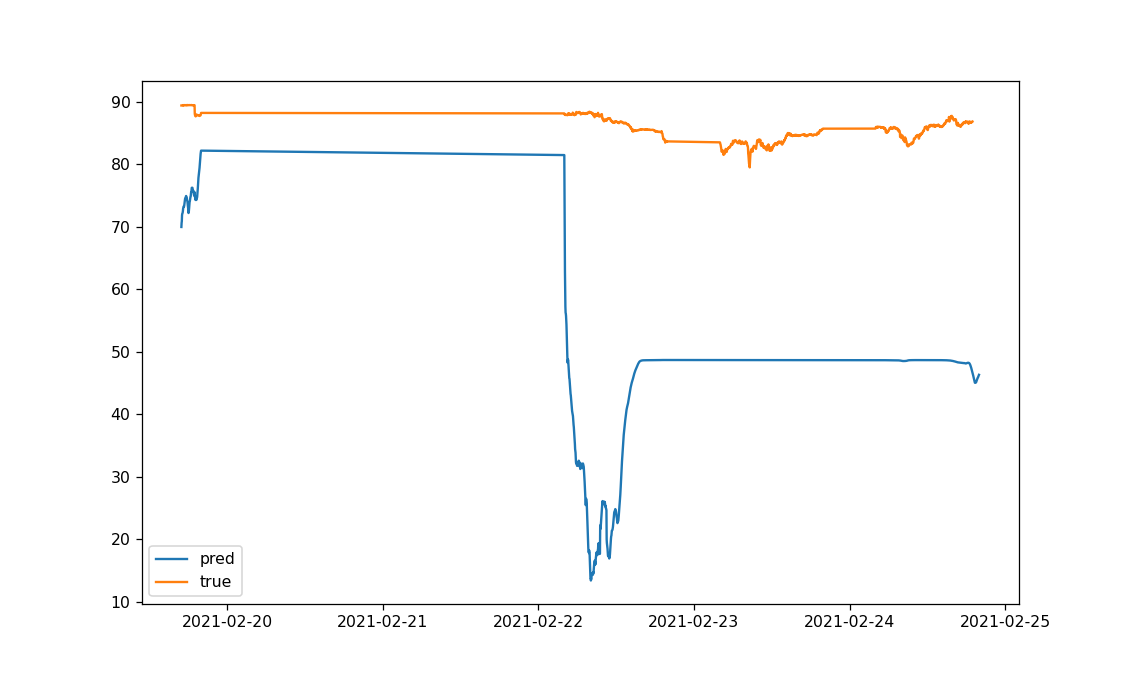

<function matplotlib.pyplot.show(block=None)>

In [37]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(test_dates_list, y_hat_descaled['adj_close'])
plt.plot(test_dates_list, test_adj_close_list)
plt.legend(['pred','true'])
plt.show